# notebook to apply sst binning to all data from wind lidar, raman lidar, cloud radar etc 

In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
from myFunctions import lcl
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

reading data from tsg and create SST dataset

In [2]:
# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

# opening ship data and reading sst
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)


definition of the functions for: 
- Interpolation of the SST on the time grid of each instrument
- binning of the data over SST grid


In [3]:
# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    
def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)


def f_calculate_binned_data(data_input, SST_binned_arr):
    
    ''' function to calculate mean values of all variables for each SST bin, for all instruments
    author: Claudia Acquistapace
    date: 20 Sept 2021
    input: - data_input: input xarray dataset containing the variables as a function of time, height, to be averaged
            - SST_binned_arr: numpy array of sst binned values for calculating the mean 
    output: dataset_concat: xarray dataset of concatenated values with mean profiles corresponding to the sst bins. A variable n_el counts the number of profiles averaged together
    '''
    # calculating mean quantities f
    dataset_mean = []

    data_input = data_input.load()

    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = data_merged.where((data_input.SST > SST_binned_arr[ind_bin]) & (data_input.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el

        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


    # concatenating datasets corresponding to SST bins on a new bin dimension
    dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    return(dataset_concat)

Reading data from Arthus for T, wvmr, SHF, LHF.

In [4]:
# reading water vapor mixing ratio data from Diego
path_arthus = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_arthus/case_1/'
arthus_wvmr_file_1 = path_arthus+"/20200202_000008_MRme_10s_97m.cdf"
arthus_wvmr_file_2 = path_arthus+"/20200203_000005_MRme_10s_97m.cdf"

# removing time duplicates in the two datasets
arthus_wvmr_1 = xr.open_dataset(arthus_wvmr_file_1)
arthus_wvmr_2 = xr.open_dataset(arthus_wvmr_file_2)

# removing double time stamps in time arrays
_, index = np.unique(arthus_wvmr_1['Time'], return_index=True)
arthus_data_wvmr_1 = arthus_wvmr_1.isel(Time=index)
_, index = np.unique(arthus_wvmr_2['Time'], return_index=True)
arthus_data_wvmr_2 = arthus_wvmr_2.isel(Time=index)

# temperature files from Diego
arthus_T_file_1 = path_arthus+"/20200202_000008_Tme_10s_97m.cdf"
arthus_T_file_2 = path_arthus+"/20200203_000005_Tme_10s_97m.cdf"

# removing time duplicates in the two datasets
arthus_T_1 = xr.open_dataset(arthus_T_file_1)
arthus_T_2 = xr.open_dataset(arthus_T_file_2)

# removing double time stamps in time arrays
_, index = np.unique(arthus_T_1['Time'], return_index=True)
arthus_data_T_1 = arthus_T_1.isel(Time=index)
_, index = np.unique(arthus_T_2['Time'], return_index=True)
arthus_data_T_2 = arthus_T_2.isel(Time=index)


# creating dataset containg T, wvmr at 10 s resolution
arthus_all = xr.merge([arthus_data_T_1, arthus_data_T_2, arthus_data_wvmr_1, arthus_data_wvmr_2])
arthus_all = arthus_all.rename_dims({'Time':'time'})
arthus_all = arthus_all.rename_dims({'Height':'height'})
arthus_all = arthus_all.rename({'Time':'time'})
arthus_all = arthus_all.rename({'Height':'height'})


In [5]:
# applying interpolating and binning functions to arthus_all data

arthus_all_SST = f_interpolate_SST_and_merge(SST_DS, arthus_all)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)
# calculating mean quantities f
dataset_mean = []


# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = arthus_all_SST.where((arthus_all_SST.SST > SST_binned_arr[ind_bin]) & (arthus_all_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


# concatenating datasets corresponding to SST bins on a new bin dimension
arthus_all_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')

In [6]:

# reading arthus data for latent heat flux
path_arthus = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_arthus/case_1/'
arthus_files = np.sort(glob.glob(path_arthus+"/*_LHF.cdf"))
arthus_files_SHF = np.sort(glob.glob(path_arthus+"/*_SHF.cdf"))

# removing time duplicates in the two datasets
arthus_1 = xr.open_dataset(arthus_files[0])
arthus_2 = xr.open_dataset(arthus_files[1])
_, index = np.unique(arthus_1['Time'], return_index=True)
arthus_1 = arthus_1.isel(Time=index)
_, index = np.unique(arthus_2['Time'], return_index=True)
arthus_2 = arthus_2.isel(Time=index)


# removing time duplicates in the two datasets
arthus_1_SHF = xr.open_dataset(arthus_files_SHF[0])
arthus_2_SHF = xr.open_dataset(arthus_files_SHF[1])
_, index = np.unique(arthus_1_SHF['Time'], return_index=True)
arthus_1_SHF = arthus_1_SHF.isel(Time=index)
_, index = np.unique(arthus_2_SHF['Time'], return_index=True)
arthus_2_SHF = arthus_2_SHF.isel(Time=index)

# merging them to create one single arthus data file
arthus_fluxes = xr.merge([arthus_1, arthus_2, arthus_1_SHF, arthus_2_SHF])
arthus_fluxes = arthus_fluxes.rename_dims({'Time':'time'})
arthus_fluxes = arthus_fluxes.rename_dims({'Height':'height'})
arthus_fluxes = arthus_fluxes.rename({'Time':'time'})
arthus_fluxes = arthus_fluxes.rename({'Height':'height'})



In [7]:
# applying interpolating and binning functions to arthus_fluxes data

arthus_fluxes_SST = f_interpolate_SST_and_merge(SST_DS, arthus_fluxes)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)
# calculating mean quantities f
dataset_mean = []


# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = arthus_fluxes_SST.where((arthus_fluxes_SST.SST > SST_binned_arr[ind_bin]) & (arthus_fluxes_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


# concatenating datasets corresponding to SST bins on a new bin dimension
arthus_fluxes_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')

Reading wind lidar data for vertical velocity and horizontal wind speed and direction 

In [8]:
# read wind lidar data
path_wind_lidar = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_wind_lidar/"
wind_lidar_file = "wind_lidar_eurec4a.nc"
path_fig = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/\
SST_impact_work/plots/"
wind_lidar = xr.open_dataset(path_wind_lidar+wind_lidar_file)

# selecting time interval to extract from wind lidar dataset
w_wind_DS = wind_lidar.sel(time=slice(t_start, t_end))

# reading horizontal wind and speed data
path_Doppler_lidar = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/doppler_lidar/case_1/'
file_1_speed = '20200202_DL_Wind_Speed.nc'
speed_data_1 = xr.open_dataset(path_Doppler_lidar+file_1_speed)
file_2_speed = '20200203_DL_Wind_Speed.nc'
speed_data_2 = xr.open_dataset(path_Doppler_lidar+file_2_speed)


file_1_dir = '20200202_DL_Wind_Direction.nc'
dir_data_1 = xr.open_dataset(path_Doppler_lidar+file_1_dir)

file_2_dir = '20200203_DL_Wind_Direction.nc'
dir_data_2 = xr.open_dataset(path_Doppler_lidar+file_2_dir)

speed_data = xr.merge([speed_data_1, speed_data_2])
dir_data = xr.merge([dir_data_1, dir_data_2])
H_wind_DS = xr.merge([speed_data, dir_data])

# renaming time and height in homogeneous way
H_wind_DS = H_wind_DS.rename_dims({'Time':'time'})
H_wind_DS = H_wind_DS.rename_dims({'Height':'height'})
H_wind_DS = H_wind_DS.rename({'Time':'time'})
H_wind_DS = H_wind_DS.rename({'Height':'height'})

In [9]:
# applying interpolating and binning functions to Horizontal wind data

H_wind_SST = f_interpolate_SST_and_merge(SST_DS, H_wind_DS)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)
# calculating mean quantities f
dataset_mean = []


# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = H_wind_SST.where((H_wind_SST.SST > SST_binned_arr[ind_bin]) & (H_wind_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


# concatenating datasets corresponding to SST bins on a new bin dimension
H_wind_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')

In [10]:
# applying interpolating and binning functions to Horizontal wind data

V_wind_SST = f_interpolate_SST_and_merge(SST_DS, w_wind_DS)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)
# calculating mean quantities f
dataset_mean = []


# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = V_wind_SST.where((V_wind_SST.SST > SST_binned_arr[ind_bin]) & (V_wind_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


# concatenating datasets corresponding to SST bins on a new bin dimension
V_wind_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
V_wind_concat.assign_coords({"SST_binned": sst_bin_label})

<xarray.Dataset>
Dimensions:     (SST_binned: 55, height: 333)
Coordinates:
  * height      (height) float32 15.0 45.0 75.0 ... 9.945e+03 9.975e+03
  * SST_binned  (SST_binned) float64 26.3 26.32 26.35 26.37 ... 27.6 27.62 27.65
Data variables:
    w           (SST_binned, height) float64 -1.078 0.2551 ... 0.8063 1.243
    cb          (SST_binned) float64 826.5 1.262e+03 645.0 ... 909.7 925.7 952.6
    SST         (SST_binned) float64 26.3 26.32 26.34 26.37 ... 27.6 27.62 27.65
    n_elements  (SST_binned) float64 234.0 124.0 165.0 ... 453.0 367.0 340.0

In [11]:
V_wind_concat

<xarray.Dataset>
Dimensions:     (SST_binned: 55, height: 333)
Coordinates:
  * height      (height) float32 15.0 45.0 75.0 ... 9.945e+03 9.975e+03
Dimensions without coordinates: SST_binned
Data variables:
    w           (SST_binned, height) float64 -1.078 0.2551 ... 0.8063 1.243
    cb          (SST_binned) float64 826.5 1.262e+03 645.0 ... 909.7 925.7 952.6
    SST         (SST_binned) float64 26.3 26.32 26.34 26.37 ... 27.6 27.62 27.65
    n_elements  (SST_binned) float64 234.0 124.0 165.0 ... 453.0 367.0 340.0

<ipython-input-42-d0d04371a9b7>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,0].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Water_vapor_mixing_ratio.values.T, cmap='inferno', vmin=0., vmax=15)
<ipython-input-42-d0d04371a9b7>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,1].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Temperature.values.T, cmap='rainbow', vmin=

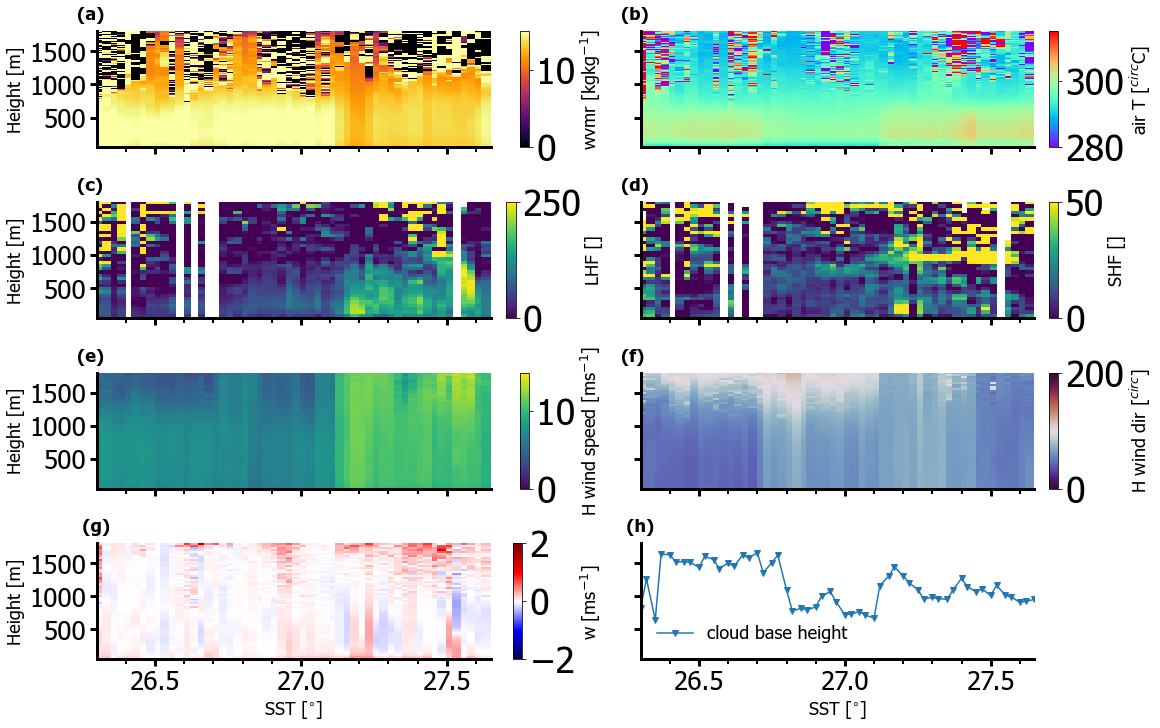

In [42]:
# composite figure variables binned in sst 

path_RS = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/radiosondes_atalante/case_1/'
font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(4, 2, figsize=(16,10), sharey=True, sharex=True, constrained_layout=True)
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
val = 18
labelsizeaxes   = val
fontSizeTitle   = val
fontSizeX       = val
fontSizeY       = val
cbarAspect      = val
fontSizeCbar    = val
green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Water_vapor_mixing_ratio.values.T, cmap='inferno', vmin=0., vmax=15)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='wvmr [kgkg$^{-1}$]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Temperature.values.T, cmap='rainbow', vmin=280., vmax=315.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='air T [$^{circ}$C]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, arthus_fluxes_concat.height.values, arthus_fluxes_concat.Latent_heat_flux.values.T, cmap='viridis', vmin=0., vmax=250.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='LHF []',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, arthus_fluxes_concat.height.values, arthus_fluxes_concat.Sensible_heat_flux.values.T, cmap='viridis', vmin=0., vmax=50.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF []', size=fontSizeX)
axs[1,1].set_ylim(200,1500)


mesh = axs[2,0].pcolormesh(sst_bin_label, H_wind_concat.height.values, H_wind_concat.Horizontal_Wind_Speed.values.T, cmap='viridis', vmin=0., vmax=15.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[2,0])
cbar.set_label(label='H wind speed [ms$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)

mesh = axs[2,1].pcolormesh(sst_bin_label, H_wind_concat.height.values, H_wind_concat.Horizontal_Wind_Direction.values.T, cmap='twilight_shifted', vmin=0., vmax=200.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[2,1])
cbar.set_label(label='H wind dir [$^{circ}$]',  size=fontSizeX)


mesh = axs[3,0].pcolormesh(sst_bin_label, V_wind_concat.height.values, V_wind_concat.w.values.T, cmap='seismic', vmin=-2., vmax=2.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[3,0])
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[3,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,0].set_xlabel('SST [$^{\circ}$]', fontsize=fontSizeX)

axs[3,1].plot(sst_bin_label, V_wind_concat.cb.values, marker="v", label='cloud base height')
axs[3,1].legend(frameon=False)
axs[3,1].set_xlabel('SST [$^{\circ}$]', fontsize=fontSizeX)

count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ', ' (g)', ' (h)']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=val, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(50,1800)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_RS+'profile_lidars_binned_sst.png')

In [14]:
SST_binned_arr

array([26.283, 26.308, 26.333, 26.358, 26.383, 26.408, 26.433, 26.458,
       26.483, 26.508, 26.533, 26.558, 26.583, 26.608, 26.633, 26.658,
       26.683, 26.708, 26.733, 26.758, 26.783, 26.808, 26.833, 26.858,
       26.883, 26.908, 26.933, 26.958, 26.983, 27.008, 27.033, 27.058,
       27.083, 27.108, 27.133, 27.158, 27.183, 27.208, 27.233, 27.258,
       27.283, 27.308, 27.333, 27.358, 27.383, 27.408, 27.433, 27.458,
       27.483, 27.508, 27.533, 27.558, 27.583, 27.608, 27.633, 27.658])

In [17]:
arthus_all_concat

<xarray.Dataset>
Dimensions:                   (SST_binned: 55, height: 1334)
Coordinates:
  * height                    (height) float32 3.75 11.25 ... 9.994e+03 1e+04
Dimensions without coordinates: SST_binned
Data variables: (12/13)
    Latitude                  (SST_binned) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Longitude                 (SST_binned) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ZSL                       (SST_binned) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Emission_Wavelength       (SST_binned) float64 354.7 354.7 ... 354.7 354.7
    Range_Resolution          (SST_binned) float64 7.5 7.5 7.5 ... 7.5 7.5 7.5
    Elevation                 (SST_binned) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                        ...
    Azimuth                   (SST_binned) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Azimuth_Resolution        (SST_binned) float64 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Temperature               (SST_binned, height) float32 281.2 ... -5.218e+03
    Water_vapor_mixing_ratio  (SST_binned, height) float32 8.815 ... -170.7
    SST                       (SST_binned) float64 26.3 26.32 ... 27.62 27.65
    n_elements                (SST_binned) float64 231.0 122.0 ... 360.0 295.0